# ISIC-2018: ResNet50 training

In [3]:
import os
import time
import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim

%matplotlib inline

import matplotlib.pyplot as plt

### Import ResNet50 model and print the layers

In [2]:
from model_resnet import Net

net = Net().cuda()
print(net)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64,

### Load dataset and visualize

In [3]:
import dataset

train_loader, val_loader = dataset.create_loaders(val_percent = 20, batch_size = 10, augment=True)

print('training_size: %d, validation_size:%d' % (len(train_loader),len(val_loader)) )

training_size: 208, validation_size:52


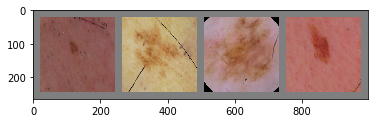

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, fnames = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4, padding=20))


## Loss functions and metrics

In [5]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def weighted_fscore_loss(prew=1, recw=1):
    def fscore_loss(y_true, y_pred):
        presci = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return -(prew+recw)*(presci * rec)/(prew*presci + recw*rec)
    return fscore_loss

### Visualizing losses and metrics with visdom
Run visdom server before executing this

In [6]:
from visualization import Visualization

learning_rate = 1e-5

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

iou_vis = Visualization('IOU / Dice Coeff.')
fpfn_vis = Visualization('False Positive / False Negative')
fscore_vis = Visualization('Precision, Recall, F-Score')
loss_vis = Visualization('Mean loss')

measures = {
    'dice_coeff': (dice_coef, iou_vis), 
    'iou': (iou, iou_vis), 
    'fp': (falsepos, fpfn_vis), 
    'fn': (falseneg, fpfn_vis), 
    'precision': (precision, fscore_vis), 
    'recall': (recall, fscore_vis), 
    'fscore': (fscore, fscore_vis) }


## Training the model
Vary number of frozen layers by naming layers to un-freeze in ```trainable```

Weight the loss function to emphasize precsion or recall by modifying ```fscores``` array

In [7]:
import train

measurement_log = []
fscores = [(2,1),(1,2)]*15 # [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
trainable = [['layer2', 'layer3','layer4']]*25 # [['layer4']]*10 + [['layer3','layer4']]*15
# fscores = [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
# frozen = [9] * 25

for epoch in range(25):
    net.freeze(trainable[epoch])
    measurements = train.fit(net, train_loader, val_loader, weighted_fscore_loss(*(fscores[epoch])), optimizer, lrscheduler, measures, epoch, loss_vis)
    measurement_log.append(measurements)
    print("Epoch: %d: " % epoch, end='')
    for k,v in measurements.items():
        print(" {}:{:.5f}".format(k,v), end=',')
    print()

Epoch: 0:  dice_coeff:0.49652, iou:0.33586, fp:15670.80792, fn:147907.60156, precision:0.83687, recall:0.35836, fscore:0.49652, train_loss:-0.55567, val_loss:-0.43956,
Epoch: 1:  dice_coeff:0.81274, iou:0.68745, fp:15362.39848, fn:22777.42860, precision:0.84790, recall:0.78523, fscore:0.81273, train_loss:-0.85089, val_loss:-0.82352,
Epoch: 2:  dice_coeff:0.78254, iou:0.64970, fp:31894.77915, fn:5301.15377, precision:0.68528, recall:0.92773, fscore:0.78253, train_loss:-0.86770, val_loss:-0.82367,
Epoch: 3:  dice_coeff:0.84442, iou:0.73409, fp:15097.40287, fn:15823.14250, precision:0.85316, recall:0.84100, fscore:0.84441, train_loss:-0.88801, val_loss:-0.84674,
Epoch: 4:  dice_coeff:0.82619, iou:0.70852, fp:25375.73528, fn:6078.07489, precision:0.75347, recall:0.92368, fscore:0.82618, train_loss:-0.88317, val_loss:-0.85522,
Epoch: 5:  dice_coeff:0.86112, iou:0.75850, fp:10754.70771, fn:17612.71695, precision:0.89569, recall:0.83266, fscore:0.86111, train_loss:-0.89767, val_loss:-0.87189,

### Save trained model and measurements

In [8]:
import csv

timestamp = time.strftime('%m%d%H%M')
outputfolder = './output/resnet-%s'%timestamp
os.mkdir(outputfolder)

# write out weights
net.save(os.path.join(outputfolder,'lesions.pth'))

# write out log
with open(os.path.join(outputfolder,'info.txt'), 'w') as f:
    f.write('%s\n' % time.strftime('%m-%d %H:%M'))
    f.write('optimizer: %s\n' % type(optimizer).__name__)
    f.write('scheduler: %s\n' % type(lrscheduler).__name__)
    f.write('learning_rate: %.6f\n' % learning_rate)
    f.write('\n')
    
with open('./output/resnet-%s/measurements.txt' % timestamp, 'w') as f:
    wr = csv.writer(f)
    wr.writerow(["Epoch"] + list(measurements.keys()))
    for epoch,measurement in enumerate(measurement_log):
        wr.writerow([epoch] + list(measurement.values()))

## Sample some images and show results

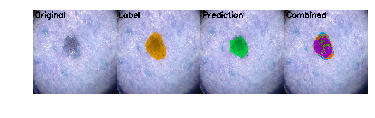

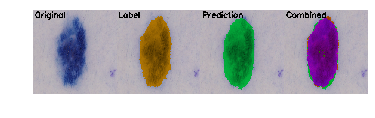

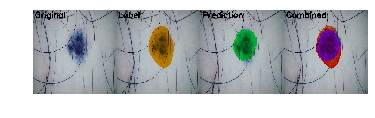

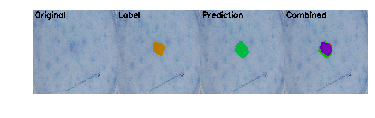

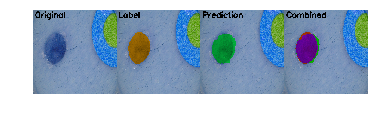

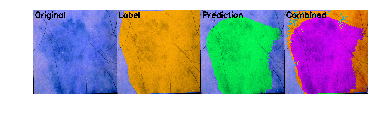

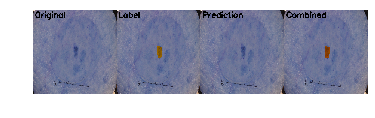

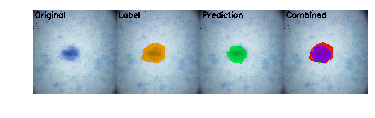

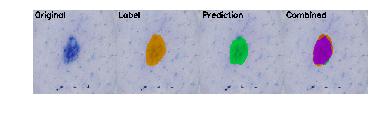

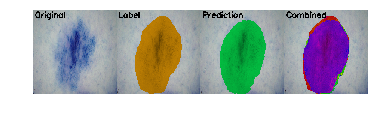

In [8]:
import eval

evaluator = eval.Evaluator(os.path.join(outputfolder,'lesions.pth'), outputfolder)
samples = evaluator.sample()

for idx in range(len(samples)):
    plt.figure()
    plt.axis('off')
    plt.imshow(samples[idx])